In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9

import tensorflow as tf
tf.test.is_gpu_available()

Wed Apr 27 20:01:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [2]:
from google.colab import drive
import pandas as pd
import numpy as np
import os
import matplotlib.pylab as plt
from tqdm import tqdm
from skimage.io import imread
import random 
random.seed(0)

from sklearn.model_selection import train_test_split
import shutil

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import cv2

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

drive.mount('/content/drive')
base = "/content/drive/MyDrive/Breast_Cancer_Classification/"

Mounted at /content/drive


##folder to dataframe

In [3]:
def findcoord(file_name): 
  tokens = file_name.split("_")
  for t in tokens: 
    if t[0] == 'x': 
      x = t[1:]
    if t[0] == 'y': 
      y = t[1:]
  return x, y

df = pd.DataFrame(columns=["patient_id", "path", "class", "x", "y"])
patient_folder = os.listdir(base)
for patient_id in tqdm(patient_folder[:100]): 
  patient_folder = base + patient_id
  for label in [0,1]: 
    class_folder = base + patient_id + "/" + str(label) + "/"
    class_files = os.listdir(class_folder)
    for c_file in class_files: 
      c_file_path = class_folder + c_file
      x, y = findcoord(c_file)
      row = {"patient_id": patient_id, "path": c_file_path, "class": label, "x": x, "y": y}
      df = df.append(row, ignore_index=True)

100%|██████████| 100/100 [17:59<00:00, 10.79s/it]


## Exploratory Analysis 

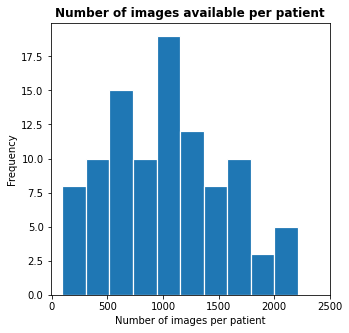

In [ ]:
no_images = df.groupby('patient_id')['path'].size()
plt.figure(figsize=(5,5))
plt.hist(no_images, bins=10, edgecolor='white', linewidth=1.2)
plt.title("Number of images available per patient", fontweight="bold")
plt.xlabel("Number of images per patient")
plt.ylabel("Frequency")
plt.xticks(np.arange(0, 2501, 500))
plt.show()

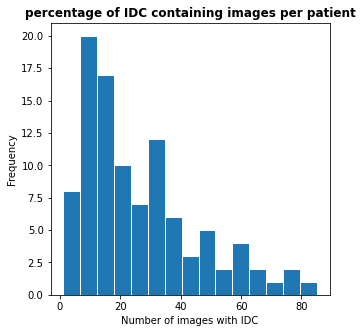

In [ ]:
df['class'] = df['class'].astype(int)
ratio = df.groupby('patient_id')['class'].value_counts() / df.groupby('patient_id')['class'].size()
ratio = ratio.loc[:,1]*100
plt.figure(figsize=(5,5))
plt.hist(ratio, bins=15, edgecolor='white')
plt.title("percentage of IDC containing images per patient", fontweight="bold")
plt.xlabel("Number of images with IDC")
plt.ylabel("Frequency")
plt.show()

In [ ]:
no_No = df.groupby("class").size()
no_No.index = no_No.index = ['Not present', 'Present']
no_No

Not present    78831
Present        24520
dtype: int64

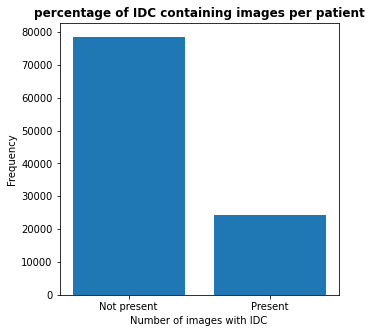

In [ ]:
plt.figure(figsize=(5,5))
plt.bar(no_No.index, no_No, edgecolor='white')
plt.title("percentage of IDC containing images per patient", fontweight="bold")
plt.xlabel("Number of images with IDC")
plt.ylabel("Frequency")
plt.show()

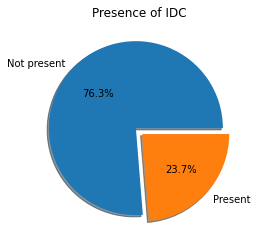

In [ ]:
no_No = df.groupby("class").size()
explode = [0.05, 0.05]
plt.pie(no_No, labels=['Not present', 'Present'], explode = explode, shadow = True, autopct='%1.1f%%')
plt.title("Presence of IDC")
plt.show()

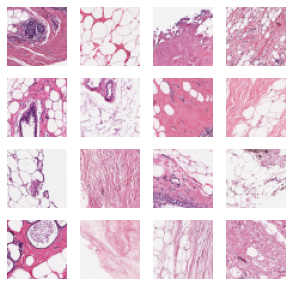

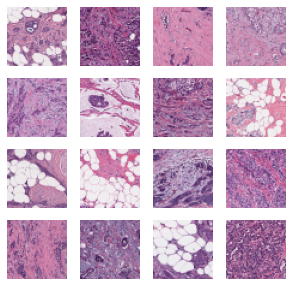

In [ ]:
def generate_Images(label): #label 0 / 1 
  image_indexs = random.sample(list(df[df['class']==label].index.values), 16)
  fig, ax = plt.subplots(4,4, figsize=(5,5))
  for row in range(4): 
    for col in range(4): 
      index = image_indexs[col + row*4]
      image = imread(df['path'][index])
      ax[row,col].imshow(image)
      ax[row,col].axis('off')
generate_Images(0)
generate_Images(1)

## image preprocessing

In [4]:
df['class'] = df['class'].astype(str)
data = df[['path', 'class']]
y = data['class']

data_train, data_test = train_test_split(data, test_size=0.20, stratify=y)
print(data_train.groupby('class').count())
print(data_test.groupby('class').count())

train_df_0 = data_train[data_train['class'] == '0'].sample(5000, random_state=42)
train_df_1 = data_train[data_train['class'] == '1'].sample(5000, random_state=42)
test_df_0 = data_test[data_test['class'] == '0'].sample(250, random_state=42)
test_df_1 = data_test[data_test['class'] == '1'].sample(250, random_state=42)
data_train = pd.concat([train_df_0, train_df_1], axis=0).reset_index(drop=True)
data_test = pd.concat([test_df_0, test_df_1], axis=0).reset_index(drop=True)

        path
class       
0      63064
1      19616
        path
class       
0      15767
1       4904


In [24]:
datagen = ImageDataGenerator(rescale=1.0/255, 
                             rotation_range=15,
                             width_shift_range=0.1, 
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=True,
                             validation_split=0.1)

test_datagen = ImageDataGenerator(rescale=1.0/255)
train_generation = datagen.flow_from_dataframe(
                                        data_train,
                                        x_col='path', y_col='class',
                                        target_size=(50,50),
                                        batch_size=10,
                                        class_mode='categorical', 
                                        subset='training')

val_generation = datagen.flow_from_dataframe(
                                        data_train,
                                        x_col='path', y_col='class',
                                        target_size=(50,50),
                                        batch_size=10,
                                        class_mode='categorical', 
                                        subset='validation')

test_generation = test_datagen.flow_from_dataframe(
                                        data_test,
                                        x_col='path', y_col='class',
                                        target_size=(50,50),
                                        batch_size=10,
                                        class_mode='categorical', 
                                        shuffle=False)

Found 9000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [6]:
def acc_loss_plot(his): 
  his_acc = his.history['accuracy']
  val_acc = his.history['val_accuracy']
  his_loss = his.history['loss']
  val_loss = his.history['val_loss']

  epochs = range(len(his_acc))
  plt.plot(epochs, his_acc, 'r', label='Training')
  plt.plot(epochs, val_acc, 'b', label='Validation')
  plt.title('Accuracy of dataset')
  plt.legend(loc=0)
  plt.figure()
  plt.show()

  epochs = range(len(his_loss))
  plt.plot(epochs, his_loss, 'r', label='Training')
  plt.plot(epochs, val_loss, 'b', label='Validation')
  plt.title('Loss of dataset')
  plt.legend(loc=0)
  plt.figure()
  plt.show()

In [49]:
target_names = ['IDC negative', 'IDC positive']

##CNN model

In [7]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

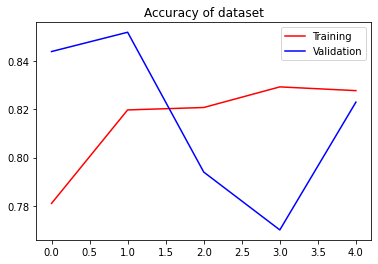

<Figure size 432x288 with 0 Axes>

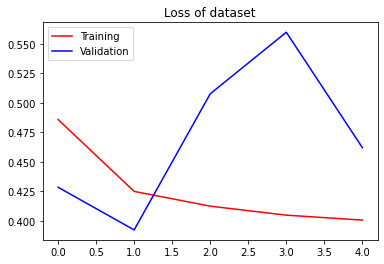

<Figure size 432x288 with 0 Axes>

50/50 [==============================] - 323s 7s/step - loss: 0.4040 - accuracy: 0.8480


[0.40397605299949646, 0.8479999899864197]

In [8]:
tf.keras.backend.clear_session()
cnn_model1 = Sequential()
cnn_model1.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(50,50,3),activation='relu'))
cnn_model1.add(MaxPool2D(pool_size=(2,2)))

cnn_model1.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
cnn_model1.add(MaxPool2D(pool_size=(2,2)))

cnn_model1.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
cnn_model1.add(MaxPool2D(pool_size=(2,2)))

cnn_model1.add(Flatten())
cnn_model1.add(Dense(128,activation='relu'))
cnn_model1.add(Dense(2,activation='softmax'))

cnn_model1.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate=1e-4), metrics= ['accuracy'])
cnn_model1.summary()

cnn_model1_history = cnn_model1.fit(train_generation,validation_data=val_generation,epochs=10, verbose=1,callbacks=early_stop)
acc_loss_plot(cnn_model1_history)
cnn_model1.evaluate(test_generation)

In [61]:
STEP_SIZE_TEST=test_generation.n//test_generation.batch_size

test_generation.reset()
pred = cnn_model1.predict_generator(test_generation,steps=STEP_SIZE_TEST,verbose=1)
ypred=np.argmax(pred,axis=1)
ytrue=test_generation.classes

print(classification_report(ytrue, ypred, target_names=target_names))
print(confusion_matrix(ytrue, ypred))

 5/50 [==>...........................] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


50/50 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

IDC negative       0.88      0.81      0.84       250
IDC positive       0.82      0.89      0.85       250

    accuracy                           0.85       500
   macro avg       0.85      0.85      0.85       500
weighted avg       0.85      0.85      0.85       500

[[202  48]
 [ 28 222]]


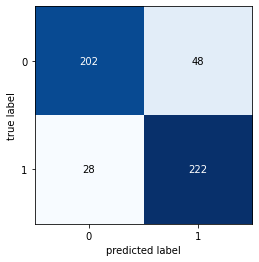

In [62]:
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(ytrue, ypred))
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 19, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 128)         204928    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

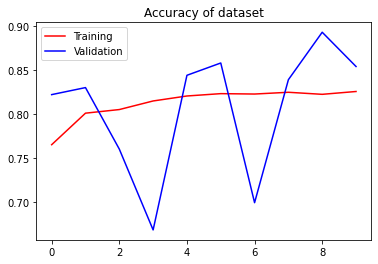

<Figure size 432x288 with 0 Axes>

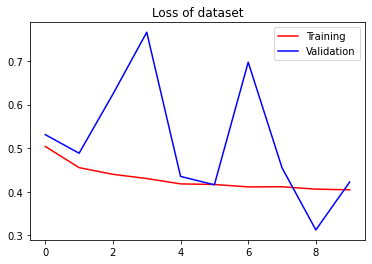

<Figure size 432x288 with 0 Axes>

50/50 [==============================] - 1s 17ms/step - loss: 0.3938 - accuracy: 0.8300


[0.3937608599662781, 0.8299999833106995]

In [18]:
tf.keras.backend.clear_session()
cnn_model2 = Sequential()
cnn_model2.add(Conv2D(filters=32,kernel_size=(5,5),input_shape=(50,50,3),activation='relu'))
cnn_model2.add(MaxPool2D(pool_size=(2,2)))

cnn_model2.add(Conv2D(filters=64,kernel_size=(5,5),activation='relu'))
cnn_model2.add(MaxPool2D(pool_size=(2,2)))

cnn_model2.add(Conv2D(filters=128,kernel_size=(5,5),activation='relu'))
cnn_model2.add(MaxPool2D(pool_size=(2,2)))

cnn_model2.add(Flatten())
cnn_model2.add(Dense(128,activation='relu'))
cnn_model2.add(Dense(2,activation='softmax'))

cnn_model2.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate=1e-4), metrics= ['accuracy'])
cnn_model2.summary()

cnn_model2_history = cnn_model2.fit(train_generation,validation_data=val_generation,epochs=10, verbose=1,callbacks=early_stop)
acc_loss_plot(cnn_model2_history)
cnn_model2.evaluate(test_generation)

In [56]:
STEP_SIZE_TEST=test_generation.n//test_generation.batch_size

test_generation.reset()
pred = cnn_model2.predict_generator(test_generation,steps=STEP_SIZE_TEST,verbose=1)
ypred=np.argmax(pred,axis=1)
ytrue=test_generation.classes

print(classification_report(ytrue, ypred, target_names=target_names))
print(confusion_matrix(ytrue, ypred))

 5/50 [==>...........................] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


50/50 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

IDC negative       0.82      0.84      0.83       250
IDC positive       0.84      0.82      0.83       250

    accuracy                           0.83       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500

[[211  39]
 [ 46 204]]


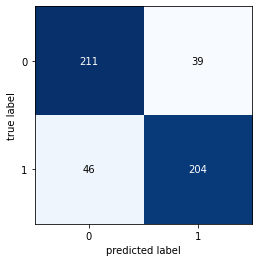

In [57]:
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(ytrue, ypred))
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 22, 22, 64)       256       
 hNormalization)                                                 
                                                        

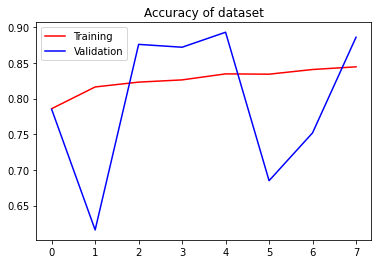

<Figure size 432x288 with 0 Axes>

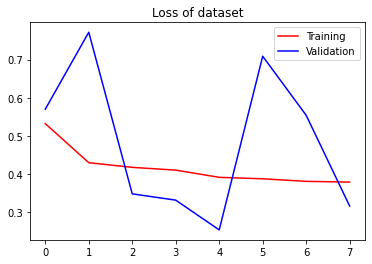

<Figure size 432x288 with 0 Axes>

50/50 [==============================] - 1s 16ms/step - loss: 0.4102 - accuracy: 0.8280


[0.41022393107414246, 0.828000009059906]

In [19]:
tf.keras.backend.clear_session()
cnn_model3 = Sequential()
cnn_model3.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(50,50,3),activation='relu'))
cnn_model3.add(BatchNormalization())
cnn_model3.add(MaxPool2D(pool_size=(2,2)))

cnn_model3.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
cnn_model3.add(BatchNormalization())
cnn_model3.add(MaxPool2D(pool_size=(2,2)))

cnn_model3.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
cnn_model3.add(BatchNormalization())
cnn_model3.add(MaxPool2D(pool_size=(2,2)))

cnn_model3.add(Flatten())
cnn_model3.add(Dense(128,activation='relu'))
cnn_model3.add(Dense(2,activation='softmax'))

cnn_model3.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate=1e-4), metrics= ['accuracy'])
cnn_model3.summary()

cnn_model3_history = cnn_model3.fit(train_generation,validation_data=val_generation,epochs=10, verbose=1,callbacks=early_stop)
acc_loss_plot(cnn_model3_history)
cnn_model3.evaluate(test_generation)


In [58]:
STEP_SIZE_TEST=test_generation.n//test_generation.batch_size

test_generation.reset()
pred = cnn_model3.predict_generator(test_generation,steps=STEP_SIZE_TEST,verbose=1)
ypred=np.argmax(pred,axis=1)
ytrue=test_generation.classes

print(classification_report(ytrue, ypred, target_names=target_names))
print(confusion_matrix(ytrue, ypred))

 5/50 [==>...........................] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


50/50 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

IDC negative       0.78      0.91      0.84       250
IDC positive       0.89      0.75      0.81       250

    accuracy                           0.83       500
   macro avg       0.84      0.83      0.83       500
weighted avg       0.84      0.83      0.83       500

[[227  23]
 [ 63 187]]


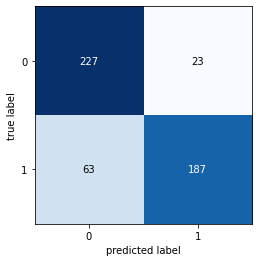

In [59]:
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(ytrue, ypred))
plt.show()

##ResNet-50 pretrained model

In [20]:
pretrained_model = tf.keras.applications.ResNet50(input_shape=(50,50,3),include_top=False,weights='imagenet',pooling='max')
pretrained_model.trainable = False
inputs = pretrained_model.input
x = pretrained_model.output
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
resnet_model = tf.keras.Model(inputs=inputs, outputs=outputs)
resnet_model.compile(Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

resnet_history = resnet_model.fit(train_generation, validation_data=val_generation, epochs=10, verbose=1, callbacks=early_stop)

94781440/94765736 [==============================] - 2s 0us/step
Epoch 1/10
900/900 [==============================] - 33s 33ms/step - loss: 0.6644 - accuracy: 0.6031 - val_loss: 0.8300 - val_accuracy: 0.2840
Epoch 2/10
900/900 [==============================] - 29s 32ms/step - loss: 0.6308 - accuracy: 0.6469 - val_loss: 0.7501 - val_accuracy: 0.4380
Epoch 3/10
900/900 [==============================] - 29s 32ms/step - loss: 0.6118 - accuracy: 0.6641 - val_loss: 0.6172 - val_accuracy: 0.6420
Epoch 4/10
900/900 [==============================] - 30s 34ms/step - loss: 0.5992 - accuracy: 0.6848 - val_loss: 0.8839 - val_accuracy: 0.2830
Epoch 5/10
900/900 [==============================] - 29s 32ms/step - loss: 0.5835 - accuracy: 0.6990 - val_loss: 0.5516 - val_accuracy: 0.7320
Epoch 6/10
900/900 [==============================] - 29s 33ms/step - loss: 0.5775 - accuracy: 0.7016 - val_loss: 0.6412 - val_accuracy: 0.6200
Epoch 7/10
900/900 [==============================] - 29s 32ms/step - l

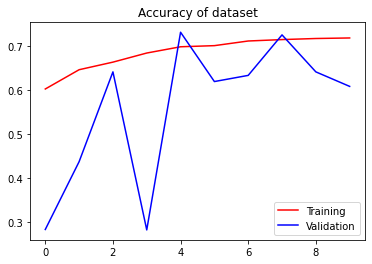

<Figure size 432x288 with 0 Axes>

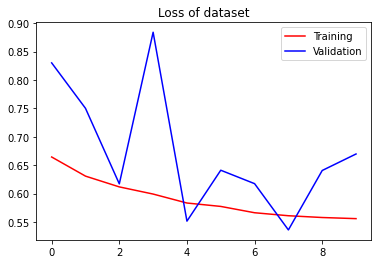

<Figure size 432x288 with 0 Axes>

50/50 [==============================] - 1s 21ms/step - loss: 0.5943 - accuracy: 0.6520


[0.5942956209182739, 0.6520000100135803]

In [23]:
acc_loss_plot(resnet_history)
resnet_model.evaluate(test_generation)

In [38]:
STEP_SIZE_TEST=test_generation.n//test_generation.batch_size

test_generation.reset()
pred = resnet_model.predict_generator(test_generation,steps=STEP_SIZE_TEST,verbose=1)
ypred=np.argmax(pred,axis=1)
ytrue=test_generation.classes

print(classification_report(ytrue, ypred, target_names=target_names))
print(confusion_matrix(ytrue, ypred))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


50/50 [==============================] - 1s 20ms/step
              precision    recall  f1-score   support

IDC negative       0.78      0.43      0.55       250
IDC positive       0.60      0.88      0.72       250

    accuracy                           0.65       500
   macro avg       0.69      0.65      0.63       500
weighted avg       0.69      0.65      0.63       500

[[107 143]
 [ 31 219]]


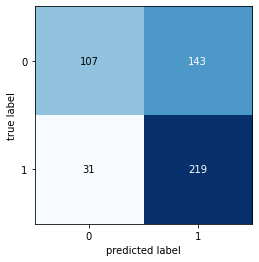

In [48]:
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(ytrue, ypred))
plt.show()

## DenseNet

Epoch 1/10
900/900 [==============================] - 49s 45ms/step - loss: 0.4675 - accuracy: 0.7813 - val_loss: 0.5009 - val_accuracy: 0.7770
Epoch 2/10
900/900 [==============================] - 37s 42ms/step - loss: 0.4140 - accuracy: 0.8201 - val_loss: 0.4941 - val_accuracy: 0.7940
Epoch 3/10
900/900 [==============================] - 38s 42ms/step - loss: 0.4038 - accuracy: 0.8223 - val_loss: 0.4880 - val_accuracy: 0.7970
Epoch 4/10
900/900 [==============================] - 38s 42ms/step - loss: 0.3992 - accuracy: 0.8234 - val_loss: 0.5367 - val_accuracy: 0.7580
Epoch 5/10
900/900 [==============================] - 37s 42ms/step - loss: 0.3915 - accuracy: 0.8294 - val_loss: 0.5628 - val_accuracy: 0.7440
Epoch 6/10
900/900 [==============================] - 38s 42ms/step - loss: 0.3839 - accuracy: 0.8320 - val_loss: 0.4752 - val_accuracy: 0.7920
Epoch 7/10
900/900 [==============================] - 37s 42ms/step - loss: 0.3872 - accuracy: 0.8316 - val_loss: 0.5227 - val_accuracy:

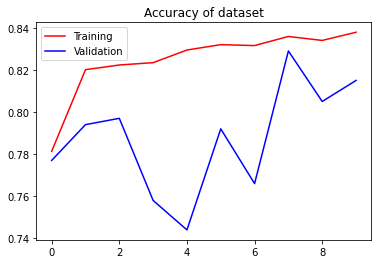

<Figure size 432x288 with 0 Axes>

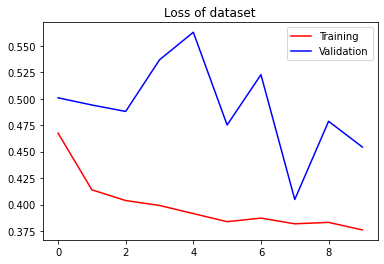

<Figure size 432x288 with 0 Axes>

50/50 [==============================] - 2s 34ms/step - loss: 0.4028 - accuracy: 0.8360


[0.4027656018733978, 0.8360000252723694]

In [41]:
tf.keras.backend.clear_session()
pretrained_model = tf.keras.applications.DenseNet201(input_shape=(50,50,3),include_top=False,weights='imagenet',pooling='max')
pretrained_model.trainable = False
inputs = pretrained_model.input
x = pretrained_model.output
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
densenet_model = tf.keras.Model(inputs=inputs, outputs=outputs)
densenet_model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

densenet_history = densenet_model.fit(train_generation, validation_data=val_generation, epochs=10, verbose=1, callbacks=early_stop)
acc_loss_plot(densenet_history)
densenet_model.evaluate(test_generation)

In [52]:
STEP_SIZE_TEST=test_generation.n//test_generation.batch_size

test_generation.reset()
pred = densenet_model.predict_generator(test_generation,steps=STEP_SIZE_TEST,verbose=1)
ypred=np.argmax(pred,axis=1)
ytrue=test_generation.classes

target_names = ['IDC negative', 'IDC positive']
print(classification_report(ytrue, ypred, target_names=target_names))
print(confusion_matrix(ytrue, ypred))

 3/50 [>.............................] - ETA: 1s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


50/50 [==============================] - 2s 31ms/step
              precision    recall  f1-score   support

IDC negative       0.89      0.76      0.82       250
IDC positive       0.79      0.91      0.85       250

    accuracy                           0.84       500
   macro avg       0.84      0.84      0.84       500
weighted avg       0.84      0.84      0.84       500

[[191  59]
 [ 23 227]]


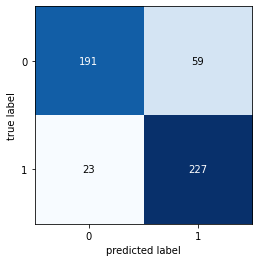

In [53]:
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(ytrue, ypred))
plt.show()